In [45]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [46]:
with open('/datax/scratch/andresl/starlink-pipeline-runs/sample-run/logs/all_logs.log', 'r') as f:
    lines = pd.Series(f.readlines())

In [47]:
lines.iloc[-2]

'2025-07-31 17:47:55,717 | DEBUG | rfi_pipeline.filejob (blc40_guppi_58841_61440_NGC5638_0080.gpuspec.0000.h5) (14780): Done loading block, took 0.00245s.\n'

In [66]:
loading = lines.str.extract(
    r'\((?P<file>.*)\) \((?P<pid>\d+)\): Done (?P<which>loading) block, took (?P<time>[\d\.e\+\-]+)s\.\n'
)

fitting = lines.str.extract(
    r'\((?P<file>.*)\) \((?P<pid>\d*)\): Done (?P<which>fitting) Gaussians, took (?P<time>[e+\-\d\.]+)s\.\n'
)

hits = lines.str.extract(
    r'\((?P<file>.*)\) \((?P<pid>\d+)\): Done getting (?P<which>hits), took (?P<time>[\d+\-\.e]+)s\n'
)

filtering = lines.str.extract(
    r'\((?P<file>.*)\) \((?P<pid>\d+)\): Done (?P<which>filtering) blocks, took (?P<time>[\d\.e+\-]+)s\.\n'
)

times = (loading
         .combine_first(fitting)
         .combine_first(hits)
         .combine_first(filtering)
         .dropna()
         .reset_index(drop=True)
         .reset_index())
times['time'] = times['time'].astype(float)

times

,index,file,pid,which,time
0,0,blc00_guppi_58812_48175_PSR_B0950+08_0010.gpus...,14776,loading,0.02750
1,1,blc40_guppi_58841_61440_NGC5638_0080.gpuspec.0...,14780,fitting,0.04700
2,2,blc40_guppi_58841_61440_NGC5638_0080.gpuspec.0...,14780,loading,0.00195
3,3,blc00_guppi_58812_48175_PSR_B0950+08_0010.gpus...,14776,fitting,0.03840
4,4,blc40_guppi_58841_61440_NGC5638_0080.gpuspec.0...,14780,fitting,0.04830
...,...,...,...,...,...
6454,6454,blc40_guppi_58841_61440_NGC5638_0080.gpuspec.0...,14780,loading,0.00206
6455,6455,blc00_guppi_58812_48175_PSR_B0950+08_0010.gpus...,14776,fitting,0.04380
6456,6456,blc40_guppi_58841_61440_NGC5638_0080.gpuspec.0...,14780,fitting,0.04540
6457,6457,blc40_guppi_58841_61440_NGC5638_0080.gpuspec.0...,14780,loading,0.00245


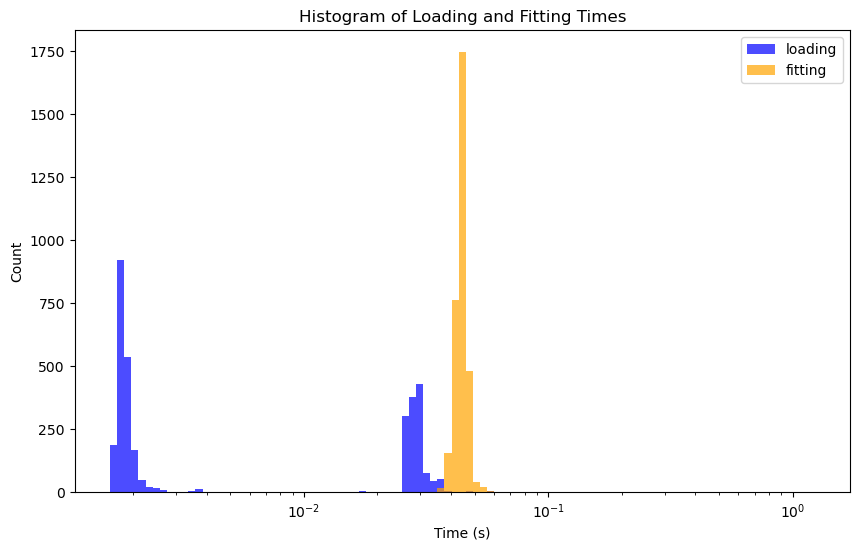

In [83]:
# Define log-spaced bins covering the range of all times
load_and_fit = times[times['which'].isin(['loading', 'fitting'])]
min_time = load_and_fit['time'].min()
max_time = load_and_fit['time'].max()
bins = np.logspace(np.log10(min_time), np.log10(max_time), 100)
# bins = 10**np.histogram_bin_edges(np.log10(load_and_fit['time']), bins='auto')

plt.figure(figsize=(10, 6))
plt.hist(times[times['which'] == 'loading']['time'], bins=bins, alpha=0.7, label='loading', color='blue')
plt.hist(times[times['which'] == 'fitting']['time'], bins=bins, alpha=0.7, label='fitting', color='orange')
plt.xscale('log')
# plt.yscale('log')
plt.xlabel('Time (s)')
plt.ylabel('Count')
plt.title('Histogram of Loading and Fitting Times')
plt.legend()
plt.show()

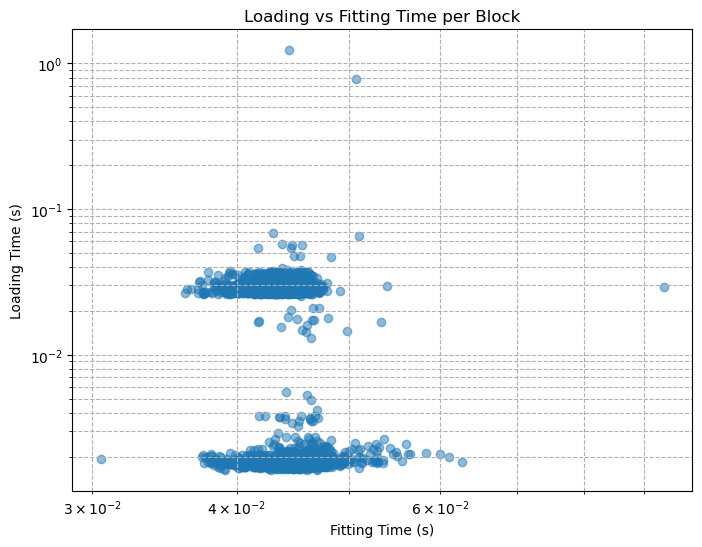

In [80]:
# Sort times by file and index to ensure adjacent rows correspond to the same block
times_sorted = times.sort_values(['file', 'index']).reset_index(drop=True)

# Find pairs of adjacent rows in 'times' where one is 'loading' and the next is 'fitting' for the same file and pid
pairs = []
for i in range(len(times_sorted) - 1):
    row1 = times_sorted.iloc[i]
    row2 = times_sorted.iloc[i + 1]
    # Only count "loading" followed by "fitting" for the same file and pid
    if (
        row1['file'] == row2['file']
        and row1['pid'] == row2['pid']
        and row1['which'] == 'loading'
        and row2['which'] == 'fitting'
    ):
        pairs.append((row1['time'], row2['time']))

# Convert to numpy arrays for plotting
loading_times = np.array([p[0] for p in pairs])
fitting_times = np.array([p[1] for p in pairs])

plt.figure(figsize=(8, 6))
plt.scatter(fitting_times, loading_times, alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Fitting Time (s)')
plt.ylabel('Loading Time (s)')
plt.title('Loading vs Fitting Time per Block')
plt.grid(True, which="both", ls="--")
plt.show()

In [84]:
# Calculate the ratio of fitting time to loading time for each pair
ratios = [fit / load for load, fit in pairs if load > 0]

# Compute the average ratio
average_ratio = np.mean(ratios)
print(f"On average, fitting takes {average_ratio:.2f} times longer than loading.")

On average, fitting takes 14.91 times longer than loading.
